# Automated Feature Engineering

In this notebook, we will try our hand at automated feature engineering with the retail entity set. The objective is to predict whether or not a customer will spend more than \$500 in the next 30 days.

## Roadmap 

1. Format Data into an entityset
2. Develop a prediction problem
    * Create a dataframe of labels and cutoff times
    * Each customer can appear multiple times as a different label
3. Run deep feature sythesis on the entity to make features
    * Use the cutoff times to make features using valid data for each labels
4. Use the features to train a machine learning model
5. Tune deep feature synthesis 
6. Use random search for hyperparamter tuning the model

This problem is a great display of featuretools because it is time-based and can be broken down into different tables. Doing this problem by hand is nearly impossible to keep track of all the different cutoff times and valid data.

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import featuretools as ft

### Load in Raw Data

The raw data is a collection of purchases from an online retailer collected in 2011. Each row in the original data represents one product that was purchased.
We'll load in the data from an s3 bucket, convert the price in Pounds to dollars (based on the exchange rate on May 31, 2011) and create a column representing the total of the purchase. 

In [2]:
csv_s3 = "s3://featurelabs-static/online-retail-logs.csv"
data = pd.read_csv(csv_s3, parse_dates=["order_date"])
# Convert to dollars
data['price'] = data['price'] * 1.65
data['total'] = data['price'] * data['quantity']

data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.2075,17850.0,United Kingdom,25.245
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,5.5935,17850.0,United Kingdom,33.561
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.5375,17850.0,United Kingdom,36.300
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,5.5935,17850.0,United Kingdom,33.561
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,5.5935,17850.0,United Kingdom,33.561


There are a few issues we need to address with the data. First, we'll drop the duplicated rows, then we'll drop any rows that contain a `nan`. Finally, we can add a `Boolean` column indicating whether or not an order is a cancellation.

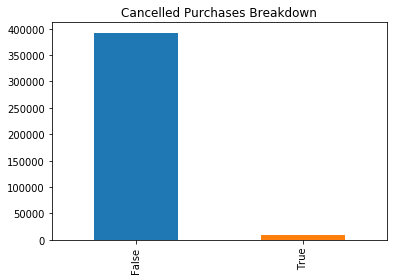

In [3]:
# drop the duplicates
data = data.drop_duplicates()

# drop rows with null customer id
data = data.dropna(axis=0)

data['cancelled'] = data['order_id'].str.startswith('C')
data['cancelled'].value_counts().plot.bar();
plt.title('Cancelled Purchases Breakdown');

All of the cancelled orders have negative quantities which mean that they cancel out with the corresponding purchase. 

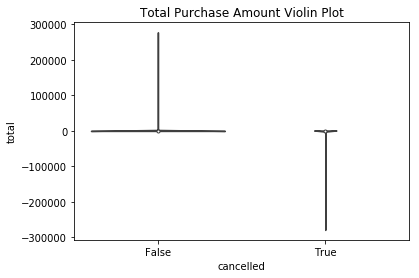

In [4]:
sns.violinplot(x = 'cancelled', y = 'total', data = data);
plt.title("Total Purchase Amount Violin Plot");

Now we can go ahead and create an `EntitySet`. Initially we'll add the entire `data` as an `entity` to the set.

In [5]:
es = ft.EntitySet(id="Online Retail Logs")

# Add the entire data table as an entity
es.entity_from_dataframe("order_products",
                         dataframe=data,
                         index="order_product_id",
                         time_index = 'order_date',
                         variable_types={'description': ft.variable_types.Text})

2018-07-26 15:32:04,019 featuretools.entityset - WARNING    index order_product_id not found in dataframe, creating new integer column


Entityset: Online Retail Logs
  Entities:
    order_products [Rows: 401604, Columns: 11]
  Relationships:
    No relationships

In order to create new tables out of the original table, we can normalize this `entity`. This creates new tables by creating a unique row for every variable that we pass in, such as the customer or the product.

In [6]:
# create a new "products" entity
es.normalize_entity(new_entity_id="products",
                    base_entity_id="order_products",
                    index="product_id",
                    additional_variables=["description"])

es['products'].df.head()

,product_id,description,first_order_products_time
21730,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00
22752,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00
71053,71053,WHITE METAL LANTERN,2010-12-01 08:26:00
84029E,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00
84029G,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00


What this has done is created a new table where every product has one row (it is normalized by the product). The `first_order_products_time` represents the first time the `product` appears in the data. We can use this table to create new features and this table is a parent of the `order_products` table with the linknage through the `product_id`.

We'll repeat the process to create tables for both the `customers` and the `orders`. Using `normalize_entity` automatically creates the relationships and time index so we don't have to do that ourselves.

In [7]:
# create a new "orders" entity
es.normalize_entity(new_entity_id="orders",
                    base_entity_id="order_products",
                    index="order_id",
                    additional_variables=[
                        "customer_id", "country", 'cancelled'])

# create a new "customers" entity based on the orders entity
es.normalize_entity(new_entity_id="customers",
                    base_entity_id="orders",
                    index="customer_id")

es

Entityset: Online Retail Logs
  Entities:
    order_products [Rows: 401604, Columns: 7]
    products [Rows: 3684, Columns: 3]
    orders [Rows: 22190, Columns: 5]
    customers [Rows: 4372, Columns: 2]
  Relationships:
    order_products.product_id -> products.product_id
    order_products.order_id -> orders.order_id
    orders.customer_id -> customers.customer_id

The next step is to define the prediction problem.

# Prediction Problem

The goal of machine learning is to predict some quantity or a label. In this case, we will make it our aim to predict whether or not a customer will spend more than \$500 in the next 30 days. However, instead of picking one point in the data and making predictions for the next 30 days, we can select multiple points in the data and ask will the customer spend \$500 over the next month. We therefore get multiple labelled training examples for each customer.

The function below takes in a start date and an end date (which we can set to 30 days apart) and generates a dataframe of the labels, which is the amount the customter spent in the period. For customers who appear in the data prior to the start date but then do have a purchase in between the start and end date, we want to set their total to 0.

In [49]:
def make_retail_cutoffs_total(start_date, end_date, threshold = 500):
    
    # Find customers who exist before start date
    customer_pool = data[data['order_date'] < start_date]['customer_id'].unique()
    tmp = pd.DataFrame({'customer_id': customer_pool})

    # For customers in the customer pool, find their sum between the start and end date
    totals = data[data['customer_id'].isin(customer_pool) & 
        (data['order_date'] > start_date) & 
        (data['order_date']<end_date)
    ].groupby('customer_id')['total'].sum().reset_index()
    
    # Merge with all the customer ids to record all customers who existed before start date
    totals = totals.merge(tmp, on = 'customer_id', how = 'right')

    # Set the total for any customer who did not have a purchase in the timeframe equal to 0
    totals['total'] = totals['total'].fillna(0)
    
    # Label is based on the threshold
    totals['label'] = (totals['total'] > threshold).astype(int)
        
    # The cutoff time is the start date
    totals['cutoff_time'] = pd.to_datetime(start_date)
    totals = totals[['customer_id', 'cutoff_time', 'total', 'label']]
    
    return totals

In [50]:
may_spending = make_retail_cutoffs_total(pd.datetime(2011, 5, 1), pd.datetime(2011, 6, 1))
may_spending.head()

,customer_id,cutoff_time,total,label
0,12372.0,2011-05-01,850.9050,1
1,12395.0,2011-05-01,547.4535,1
2,12399.0,2011-05-01,793.4850,1
3,12414.0,2011-05-01,273.6525,0
4,12415.0,2011-05-01,20940.4140,1


Because we set the total to zero for any customers who did not have a purchase, the `total` comes out to be very imbalanced. However, we cannot only count the customers who did have a purchase in the time frame because that would be essentially cheating with the data!

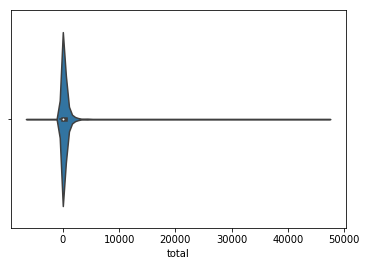

In [51]:
sns.violinplot(may_spending['total']);

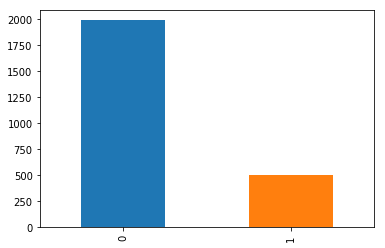

In [52]:
may_spending['label'].value_counts().plot.bar();

We also have negative spending indicating customers who only had a cancelled order in the month (or at least more cancellations than purchases). These aren't necessarily an issue because we will frame this as a binary classification problem. We can now calculate the labels for 7 more months using the threshold of \$500. At the end we will concatenate all of these into one label dataframe.

In [53]:
june_spending = make_retail_cutoffs_total('2011-06-01', '2011-07-01', 500)
july_spending = make_retail_cutoffs_total('2011-07-01', '2011-08-01', 500)
august_spending = make_retail_cutoffs_total('2011-08-01', '2011-09-01', 500)
september_spending = make_retail_cutoffs_total('2011-09-01', '2011-10-01', 500)
october_spending = make_retail_cutoffs_total('2011-10-01', '2011-11-01', 500)
november_spending = make_retail_cutoffs_total('2011-11-01', '2011-12-01', 500)
december_spending = make_retail_cutoffs_total('2011-12-01', '2012-01-01', 500)

In [54]:
labels = pd.concat([may_spending, june_spending, july_spending, august_spending, 
                    september_spending, october_spending, november_spending, december_spending], axis = 0)
labels.describe()

,customer_id,total,label
count,26809.000000,26809.000000,26809.000000
mean,15292.455929,307.491736,0.160879
std,1721.282564,1860.833564,0.367426
min,12346.000000,-5916.636000,0.000000
25%,13807.000000,0.000000,0.000000
50%,15265.000000,0.000000,0.000000
75%,16771.000000,129.624000,0.000000
max,18287.000000,115906.725000,1.000000


That gives us over 25,000 labels to work with. Each label represents one customer-month with ~16% of the labels as True. We can plot the total spending by month. 

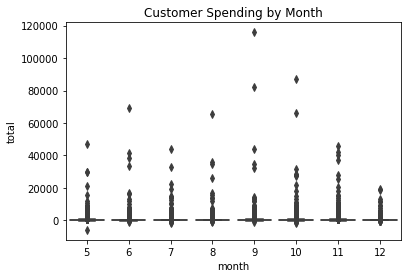

In [55]:
labels['month'] = labels['cutoff_time'].dt.month
sns.boxplot(x = 'month', y = 'total', data = labels);
plt.title('Customer Spending by Month');

In [105]:
labels['customer_id'].value_counts().sort_values(ascending = False).head()

15215.0    8
16951.0    8
17980.0    8
16942.0    8
14258.0    8
Name: customer_id, dtype: int64

In [101]:
labels.head()

,customer_id,cutoff_time,total,label,month
0,12372.0,2011-05-01,850.9050,1,5
1,12395.0,2011-05-01,547.4535,1,5
2,12399.0,2011-05-01,793.4850,1,5
3,12414.0,2011-05-01,273.6525,0,5
4,12415.0,2011-05-01,20940.4140,1,5


# Deep Feature Synthesis 

Using the labels and the entityset, we can now directly use deep feature synthesis. The following function will generate 100s of features for our problem, with one row for each customer and the columns holding the features.

In [59]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='customers',
                                       cutoff_time = labels, verbose = 2,
                                       chunk_size = len(labels), n_jobs = -1)

feature_matrix.head()

Built 143 features
EntitySet scattered to workers in 2.011 seconds
Elapsed: 11:45 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


,COUNT(orders),PERCENT_TRUE(orders.cancelled),NUM_UNIQUE(orders.country),MODE(orders.country),SUM(order_products.quantity),SUM(order_products.price),SUM(order_products.total),STD(order_products.quantity),STD(order_products.price),STD(order_products.total),...,NUM_UNIQUE(orders.MONTH(first_order_products_time)),NUM_UNIQUE(orders.WEEKDAY(first_order_products_time)),MODE(orders.MODE(order_products.product_id)),MODE(orders.DAY(first_order_products_time)),MODE(orders.YEAR(first_order_products_time)),MODE(orders.MONTH(first_order_products_time)),MODE(orders.WEEKDAY(first_order_products_time)),total,label,month
customer_id,,,,,,,,,,,,,,,,,,,,,
12346.0,2,0.500,1,United Kingdom,0,3.4320,0.0000,74215.000000,0.000000,127352.940000,...,1,1,23166,18,2011,1,1,0.0,0,5
12347.0,3,0.000,1,Iceland,1117,371.3325,3008.6595,25.986617,3.552460,44.460045,...,3,3,16008,7,2011,1,1,0.0,0,5
12348.0,3,0.000,1,Finland,2124,224.7465,2453.9460,50.127491,20.091409,74.648848,...,3,2,21213,5,2011,1,1,0.0,0,5
12350.0,1,0.000,1,Norway,197,107.7450,551.7600,4.215641,14.942464,11.646210,...,1,1,20615,2,2011,2,2,0.0,0,5
12352.0,8,0.375,1,Norway,188,3135.1155,991.9470,6.960703,157.369454,171.627342,...,2,3,21914,1,2011,3,1,0.0,0,5


In [90]:
feature_matrix = feature_matrix.drop(columns = ['total', 'label', 'month'])
feature_matrix.shape

(26809, 143)

## Preliminary modeling

At this point the matrix is ready to for modeling. We will want to one-hot encode the columns first and then we can get to machine learning. We'll make sure to split the data into a training and testing set first. 

## Metrics

The primary metric will be f1 score. 

In [91]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [92]:
feature_matrix_enc = pd.get_dummies(feature_matrix)
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_enc, labels['label'], test_size = 0.3)

In [93]:
model = RandomForestClassifier(n_estimators = 1000, random_state = 50,
                               n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [94]:
print('F1 Score: {:.5f}.'.format(f1_score(y_test, model.predict(X_test))))
print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


F1 Score: 0.46336.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s


ROC AUC Score: 0.86040.


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


## Comparison to Baseline

Now let's look at how these numbers compare to the baseline. If we use the amount the customer spent in the past month, can we use that to predict how much they will spend in the next month? We can try this for July 2011.

In [95]:
july_labels = labels[labels['month'] == 7]
june_labels = labels[labels['month'] == 6]

july_labels = july_labels.rename(columns = {'total': 'july_total'})
june_labels = june_labels.rename(columns = {'total': 'june_total'})

july_labels = july_labels.merge(june_labels[['customer_id', 'june_total']], on = 'customer_id', how = 'left')
july_labels['june_total'] = july_labels['june_total'].fillna(0)
july_labels['prediction'] = (july_labels['june_total'] > 500).astype(int)
july_labels.head()

,customer_id,cutoff_time,july_total,label,month,june_total,prediction
0,12362.0,2011-07-01,501.2040,1,7,0.0,0
1,12379.0,2011-07-01,-3.2175,0,7,0.0,0
2,12388.0,2011-07-01,1488.4485,1,7,0.0,0
3,12407.0,2011-07-01,1503.8100,1,7,0.0,0
4,12412.0,2011-07-01,620.7960,1,7,0.0,0


In [96]:
print('F1 Score: {:.5f}.'.format(f1_score(july_labels['label'], july_labels['prediction'])))
print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(july_labels['label'], july_labels['prediction'])))

F1 Score: 0.40807.
ROC AUC Score: 0.64968.


In [97]:
def informed_baseline(month_number):
    month = labels[labels['month'] == month_number]
    previous_month = labels[labels['month'] == (month_number - 1)]
    
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    month = month.merge(previous_month[['customer_id', 'previous_total']], on = 'customer_id', how = 'left')
    month['previous_total'] = month['previous_total'].fillna(0)
    month['prediction'] = (month['previous_total'] > 500).astype(int)
    
    print('F1 Score: {:.5f}.'.format(f1_score(month['label'], month['prediction'])))
    print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(month['label'], month['prediction'])))
    
    return month

In [98]:
december = informed_baseline(12)

F1 Score: 0.31055.
ROC AUC Score: 0.70341.


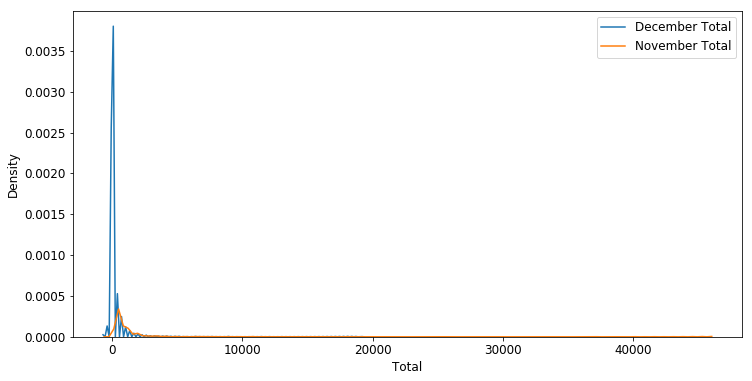

In [99]:
plt.figure(figsize = (12, 6))
sns.kdeplot(december['total'], label = 'December Total');
sns.kdeplot(december['previous_total'], label = 'November Total');
plt.legend(); plt.xlabel('Total'); plt.ylabel('Density');

From this analysis, we can conclude that machine learning delivers some value for the problem. Let's take a look at the feature importances.

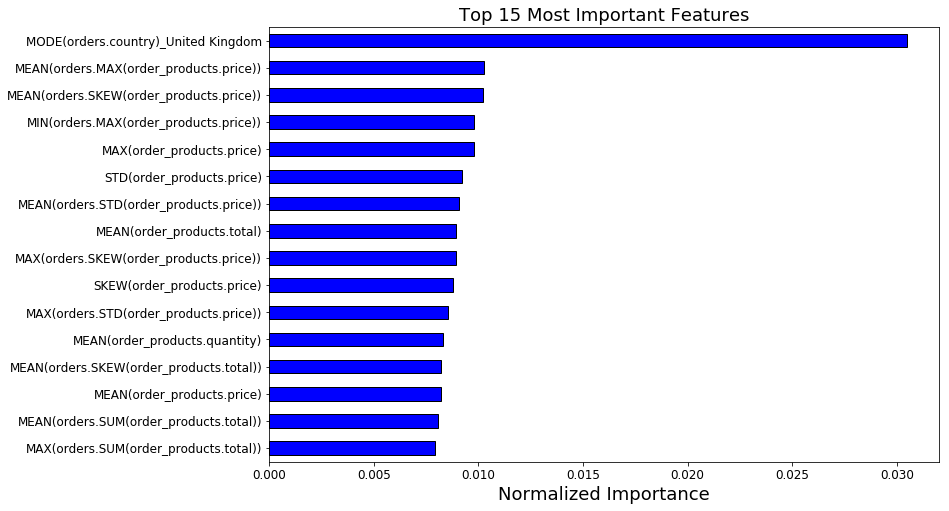

In [100]:
from utils import plot_feature_importances, feature_selection

fi = pd.DataFrame({'feature': list(feature_matrix_enc.columns),
                   'importance': model.feature_importances_})
norm_fi = plot_feature_importances(fi)

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [ ]:
x, y = ecdf(labels['total'])
plt.plot(x, y, marker = '.')
plt.xlabel('Total'); plt.ylabel('Percentile'); plt.title('ECDF of Total');

In [ ]:
es = ft.read_pickle('../input/es/')
es

In [ ]:
labels = pd.read_csv('../input/testing_cutoffs.csv', index_col=0)
cutoff_times = pd.DataFrame(labels[['customer_id', 'cutoff_time']]).rename(columns = {'cutoff_time': 'time'})
cutoff_times['time'] = pd.to_datetime(cutoff_times['time'])
cutoff_times.head()

In [ ]:
es

In [ ]:
feature_matrix, feature_names = ft.dfs(entityset = es, 
                                       target_entity='customers',
                                       cutoff_time = cutoff_times,
                                       cutoff_time_in_index = True, verbose = 2, 
                                       n_jobs = -1, chunk_size = 1000)

In [ ]:
feature_matrix.shape

In [ ]:
es = ft.EntitySet(id="Online Retail Logs")
es.entity_from_dataframe("order_products",
                         dataframe=data,
                         index="order_product_id",
                         time_index = 'order_date',
                         variable_types={'description': ft.variable_types.Text})

# create a new "products" entity
es.normalize_entity(new_entity_id="products",
                    base_entity_id="order_products",
                    index="product_id",
                    additional_variables=["description"])

# create a new "orders" entity
es.normalize_entity(new_entity_id="orders",
                    base_entity_id="order_products",
                    index="order_id",
                    additional_variables=[
                        "customer_id", "country", 'cancelled'])

# create a new "customers" entity based on the orders entity
es.normalize_entity(new_entity_id="customers",
                    base_entity_id="orders",
                    index="customer_id")

es.add_last_time_indexes()
es

In [ ]:
cutoff_times.head()

In [ ]:
cutoff_times['customer_id'].value_counts().sort_values(ascending = False)

In [ ]:
cutoff_times.isnull().sum()

In [ ]:
feature_matrix_small, feature_names = ft.dfs(entityset = es, 
                                       target_entity='customers',
                                       cutoff_time = cutoff_times[cutoff_times['customer_id'].isin([12347, 12359])],
                                       cutoff_time_in_index = True, verbose = 2, 
                                       n_jobs = 1, chunk_size = 2)

In [ ]:
feature_matrix_small

In [ ]:
feature_matrix.loc[12347.0]

In [ ]:
feature_matrix.head(20)

In [ ]:
cutoff_times.shape

In [ ]:
cutoff_times.groupby('customer_id')['time'].count()

In [ ]:
feature_matrix.groupby('customer_id')['COUNT(orders)'].count() / cutoff_times.groupby('customer_id')['time'].count()

In [ ]:
feature_matrix.groupby('customer_id')['COUNT(orders)'].count()

In [ ]:
feature_matrix.head()

In [ ]:
labels['total'].describe()

In [ ]:
labels['label'] = 1.0 * (labels['total'] > 500)
labels['label'].value_counts().plot.bar()

In [ ]:
feature_matrix.shape

In [ ]:
6543 * 5

In [ ]:
feature_matrix_enc = pd.get_dummies(feature_matrix.drop_duplicates())
feature_matrix_enc.shape

In [ ]:
labels.shape

In [ ]:
cutoff_times.shape

In [ ]:
feature_matrix.drop_duplicates().shape

In [ ]:
f = list(X_train.columns)
fi = pd.DataFrame({'feature': f, 'importance': model.feature_importances_})

In [ ]:
def plot_feature_importances(df, n = 15, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'blue', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

In [ ]:
norm_fi = plot_feature_importances(fi)

In [ ]:
cv_results = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1')
cv_results.mean()

In [ ]:
cv_results_roc = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'roc_auc')
cv_results_roc.mean()

In [ ]:
labels['cutoff_time'] = pd.to_datetime(labels['cutoff_time'])

In [ ]:
labels_september = labels[labels['cutoff_time'].dt.month == 8]
labels_september.head()

In [ ]:
labels_july = labels[labels['cutoff_time'].dt.month == 7].rename(columns = {'label': 'july', 'total': 'total_july'})
labels_july.head()

In [ ]:
labels_september = labels_september.merge(labels_july[['total_july', 'customer_id', 'july']], on = 'customer_id', how = 'left')
labels_september.head()

In [ ]:
labels_september['july'] = labels_september['july'].fillna(0)

In [ ]:
f1_score(labels_september['label'], labels_september['july'])

In [ ]:
roc_auc_score(labels_september['label'], labels_september['july'])